### Imports

In [1]:
# some imports we will need in this example

import multiDGD
import numpy as np
import anndata as ad
import scanpy as sc

### Data loading and preparation

In [2]:
# load some test data
# !!! this is just an example, you can use your own data here !!!
# all you need is to use the setup_data function on an anndata or mudata object


# in case you got some raw data, you want to prepare it but then save it so you can re-use the data splits
# for the sake of reproducibility
already_prepared = True
if not already_prepared:
    data = ad.read_h5ad('./data/human_bonemarrow/GSE194122_openproblems_neurips2021_multiome_BMMC_processed.h5ad')

    # this is an example mudata object
    data = data[::10,:] # this is just to make it smaller for the demo
    # set it up with the model (similar to MultiVI)
    # but we support both anndata and mudata objects
    data = multiDGD.functions._data.setup_data(data, modality_key='feature_types', observable_key='cell_type', covariate_keys=['Site'])
    # save this data to keep the train-val-test split for later
    data.write_h5ad('./data/human_bonemarrow/example_data.h5ad')
else:
    data = ad.read_h5ad('./data/human_bonemarrow/example_data.h5ad')

### Initializing and training the model

In [13]:
model = multiDGD.DGD(data=data, save_dir="./models/", model_name="dgd_bonemarrow_default")
model.view_data_setup()

#model.plot_latent_space()

selected  22  number of Gaussian mixture components based on the provided observable.
Covariate model initialized as:

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 4
        
The prepared data consists of the following training set:

        omicsDataset:
            Number of samples: 5539
            Modalities: ['GEX', 'ATAC']
            Features per modality: [13431, 116490]
            Total number of features: 129921
            Scaling of values: sum
        
There is also a validation set with 693 samples
And a test set with 693 samples


Preparing data loaders
Now training
training for  300  epochs with early stopping ( loss )


Training: 100%|██████████| 300/300 [29:55<00:00,  5.98s/epochs, loss=0.137, reconstruction_loss=0.128]


#######################
Training status
#######################
True


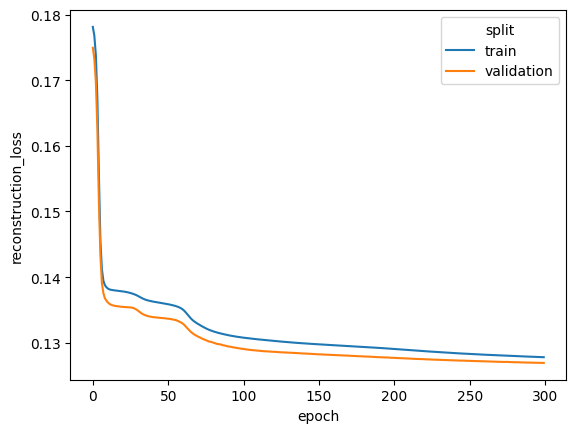

In [14]:
model.train(n_epochs=300)
model.plot_history()

In [19]:
model.save()

### Visualization and (new) data integration

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


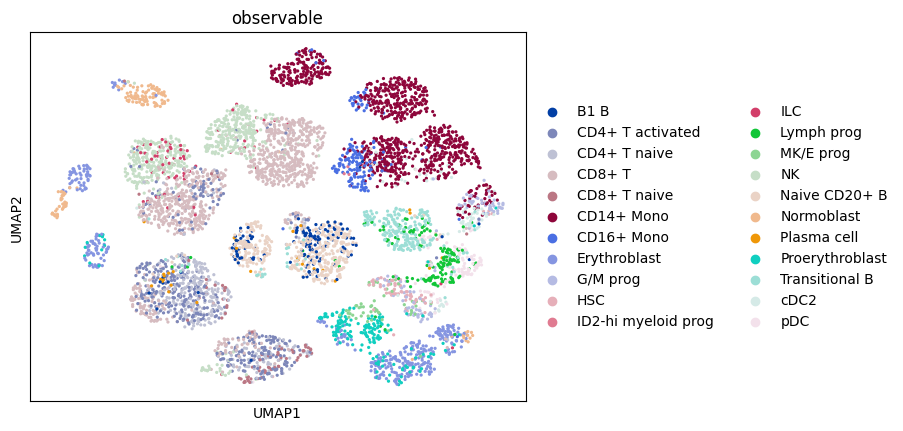

In [22]:
# visualize embeddings (scanpy conform)
# of the training data first
data_train = data.copy()[data.obs['train_val_test'] == 'train']
data_train.obsm['latent'] = model.get_representation()

sc.pp.neighbors(adata=data_train, use_rep='latent', n_neighbors=10)
sc.tl.umap(data_train, min_dist=1.0)
sc.pl.umap(data_train, color='observable')

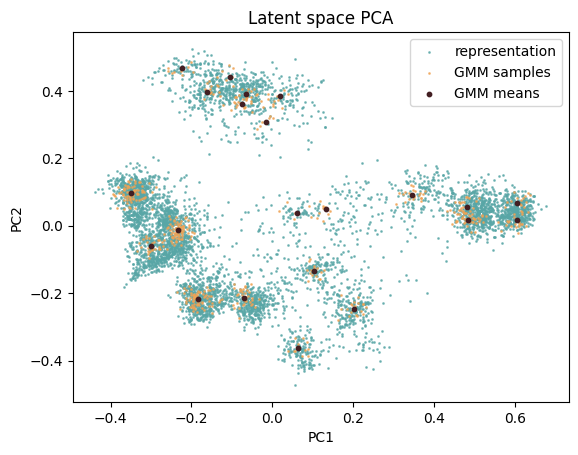

In [4]:
model.plot_latent_space()

### Model loading

In [3]:
# load model from the saved checkpoint
# models are automaticallt saved after training

model = multiDGD.DGD.load(data=data, save_dir='./models/', model_name='dgd_bonemarrow_default')

Covariate model initialized as:

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 4
        
#######################
Training status
#######################
True


In [5]:
# now test the held-out data

model.test() # same as model.predict(), all call predict_new() which is the "developer" method

making potential reps
   all potential reps:  torch.Size([88, 22])
calculating losses for each new sample and potential reps
training selected reps for  20  epochs


Training: 100%|██████████| 20/20 [05:56<00:00, 17.83s/epochs, loss=0.133, reconstruction_loss=0.129]


In [6]:
model.save()

/usr/local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


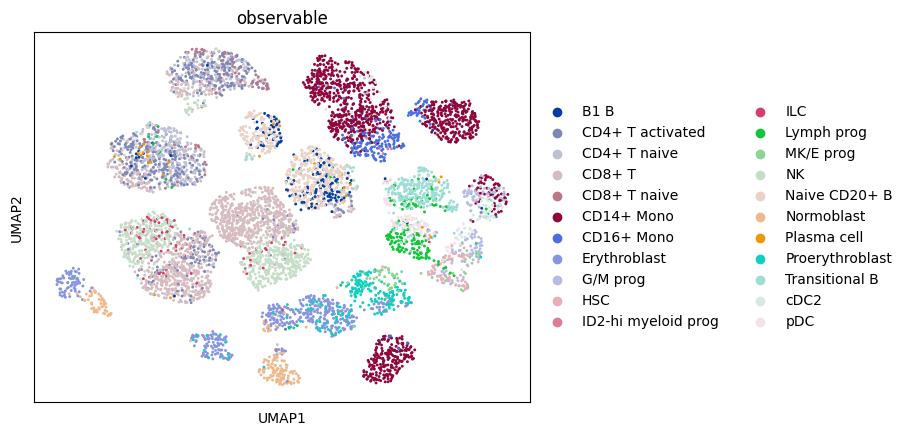

/usr/local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


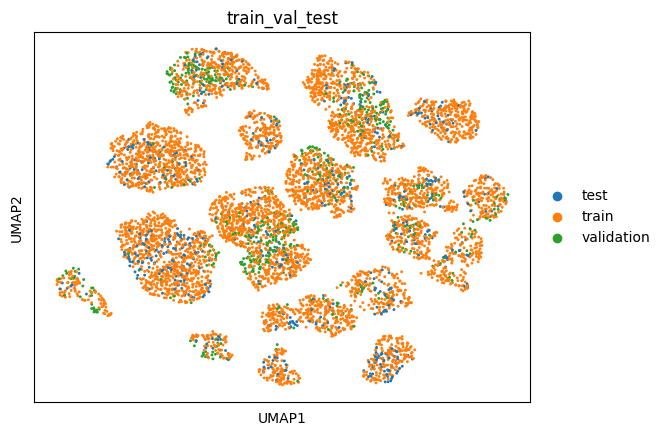

/usr/local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


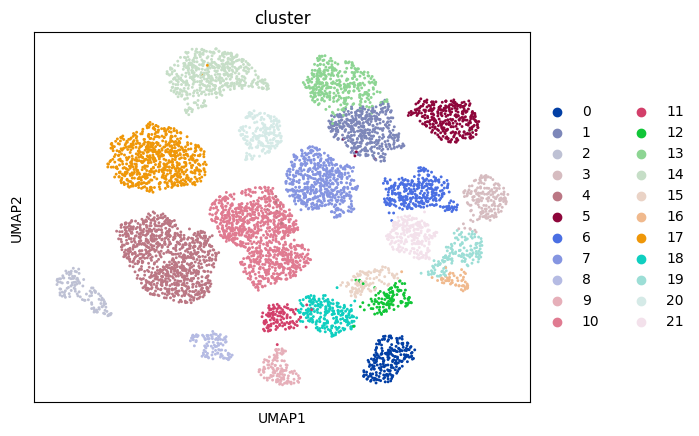

In [7]:
# now visualize the embeddings of all data (train, val, test)
# by cell type, cluster assignment and the data split

data.obsm['latent'] = model.get_representation(split='all')
data.obs['cluster'] = model.clustering(split='all').astype(str)

sc.pp.neighbors(adata=data, use_rep='latent', n_neighbors=10)
sc.tl.umap(data, min_dist=1.0)
sc.pl.umap(data, color='observable')
sc.pl.umap(data, color='train_val_test')
sc.pl.umap(data, color='cluster')